In [6]:
import pandas as pd
import geodatasets
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as ctx

import seaborn as sns

sns.set_theme(style="dark")

In [7]:
# Read the data from the file
file_path = "../tasks/04/results/kmeans_2024.txt"
with open(file_path, 'r') as file:
    data = file.readlines()

# Parse the data
parsed_data = []

for line in data:
    timestamp = int(line.split(":")[2].split(" - ")[0])
    centroids = ast.literal_eval(line.split("value: ")[1])['centroids']
    for idx, centroid in enumerate(centroids):
        parsed_data.append((timestamp, idx, centroid[0], centroid[1]))

# Create a DataFrame
df = pd.DataFrame(parsed_data, columns=['timestamp', 'centroid_id', 'lat', 'lon'])
df['time_normalized'] = (df['timestamp'] - df['timestamp'].min()) / (df['timestamp'].max() - df['timestamp'].min())
df

,timestamp,centroid_id,lat,lon,time_normalized
0,29025,0,40.586515,-74.123419,0.0
1,29025,1,40.734359,-73.978869,0.0
2,29025,2,40.827831,-73.919514,0.0
3,29025,3,40.728319,-73.810216,0.0
4,29025,4,40.645980,-73.962756,0.0
...,...,...,...,...,...
147135,58452,0,40.596276,-74.124436,1.0
147136,58452,1,40.754440,-73.973788,1.0
147137,58452,2,40.841956,-73.895870,1.0
147138,58452,3,40.726943,-73.809431,1.0


In [8]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=gpd.points_from_xy(df.lon, df.lat))
gdf

,timestamp,centroid_id,lat,lon,time_normalized,geometry
0,29025,0,40.586515,-74.123419,0.0,POINT (-74.12342 40.58652)
1,29025,1,40.734359,-73.978869,0.0,POINT (-73.97887 40.73436)
2,29025,2,40.827831,-73.919514,0.0,POINT (-73.91951 40.82783)
3,29025,3,40.728319,-73.810216,0.0,POINT (-73.81022 40.72832)
4,29025,4,40.645980,-73.962756,0.0,POINT (-73.96276 40.64598)
...,...,...,...,...,...,...
147135,58452,0,40.596276,-74.124436,1.0,POINT (-74.12444 40.59628)
147136,58452,1,40.754440,-73.973788,1.0,POINT (-73.97379 40.75444)
147137,58452,2,40.841956,-73.895870,1.0,POINT (-73.89587 40.84196)
147138,58452,3,40.726943,-73.809431,1.0,POINT (-73.80943 40.72694)


In [9]:
new_york = gpd.read_file(geodatasets.get_path("nybb")).to_crs("EPSG:4326")
new_york

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


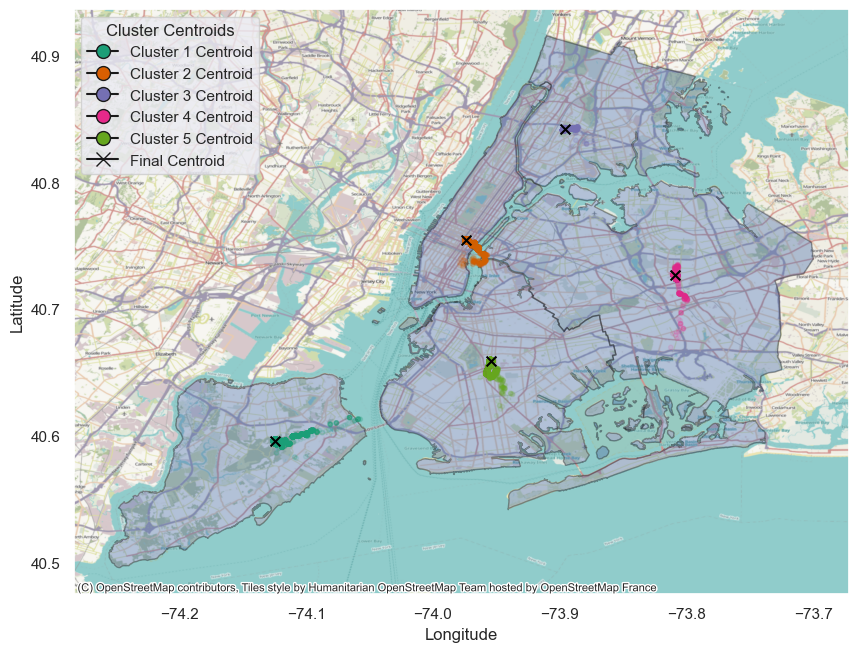

In [10]:
# Plotting the centroids
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

new_york.plot(ax=ax, alpha=0.4, edgecolor='k')

# Plot each centroid_id with a different color
colors = sns.color_palette("Dark2", len(gdf['centroid_id'].unique()))
for centroid_id in gdf['centroid_id'].unique():
    centroid_gdf = gdf[gdf['centroid_id'] == centroid_id]
    centroid_gdf.plot(
        ax=ax, 
        label=f'Cluster {centroid_id+1} centroid',
        marker='o',
        markersize=centroid_gdf['time_normalized'] * 10 + 10,  # base size, scales up
        alpha=centroid_gdf['time_normalized'].clip(lower=0.1),  # Older points are more transparent
        color=colors[centroid_id]
    )
    
    # Highlight the final centroid of each cluster
    final_point = centroid_gdf.loc[centroid_gdf['timestamp'].idxmax()]
    ax.scatter(final_point.geometry.x, final_point.geometry.y, color='black', s=50, marker='x')

# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), zoom=12)

# Set title and labels
# plt.title('Centroid Movements Over the Course of 2024')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create a custom legend
legend_elements = [Line2D([0], [0], marker='o', color='k', markerfacecolor=colors[i], markersize=10, label=f'Cluster {i+1} Centroid')
                   for i in range(len(colors))]

# Adding an entry for the final centroid markers
legend_elements.append(Line2D([0], [0], marker='x', color='k', markerfacecolor='black', markersize=10, label='Final Centroid'))

# Display the legend
ax.legend(handles=legend_elements, title="Cluster Centroids", loc='upper left')

plt.show()